In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder
from visualization import visualizeCorrelations

In [2]:
# Reading the unprocessed train dataset
df = pd.read_csv("Project Train Dataset.csv")

df.columns = df.columns.str.replace('"','').str.replace(',',';')
df.iloc[:, 0] = df.iloc[:, 0].str.replace('"','').str.replace(',',';')

df.to_csv('train.csv', index=False)

In [3]:
# Reading the processed train dataset
dataset = pd.read_csv('train.csv', sep=';')

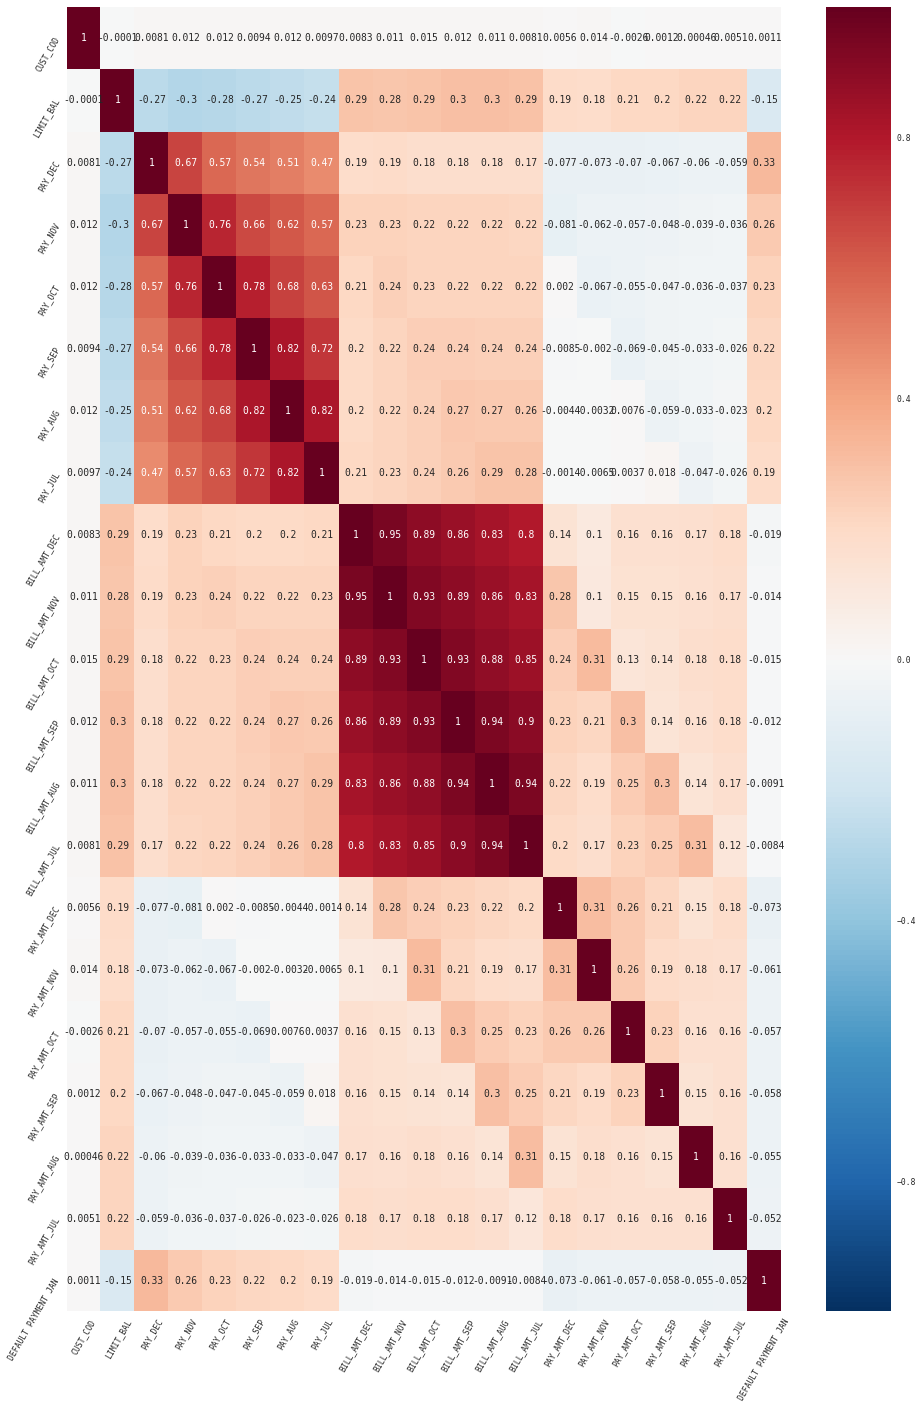

In [4]:
# Correlations
visualizeCorrelations(dataset)

In [5]:
# Filling missing values

dataset['SEX'] = dataset['SEX'].fillna('F', axis = 0)
dataset['EDUCATION'] = dataset['EDUCATION'].fillna('university', axis = 0)
dataset['MARRIAGE'] = dataset['MARRIAGE'].fillna('single', axis = 0)

# Replace negative values in PAY
dataset.loc[:,'PAY_DEC':'PAY_JUL'] = dataset.loc[:,'PAY_DEC':'PAY_JUL'].replace(to_replace = [-1, -2], value = 0)

# Calculate mean on BILL_AMT and PAY_AMT
billMean = dataset.loc[:,'BILL_AMT_DEC': 'BILL_AMT_JUL'].mean(axis = 1)
payMean = dataset.loc[:,'PAY_AMT_DEC': 'PAY_AMT_JUL'].mean(axis = 1)
dataset['BILL_AMT_DEC'] = billMean 
dataset['PAY_AMT_DEC'] = payMean

dataset = dataset.drop(['BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL'], 1) 
dataset = dataset.drop(['PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL'], 1)

# Age preprocessing
from datetime import date, datetime
import time

def calculate_age(born):
	if isinstance(born, float):
		return born
	born = datetime.strptime(born, "%d/%m/%Y")
	today = date.today()
	return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

dataset["BIRTH_DATE"] = dataset["BIRTH_DATE"].map(lambda x: calculate_age(x))

# Filling missing values for age
imputer = Imputer(missing_values = np.nan, strategy="median", axis = 1)
dataset.iloc[:, 5] = imputer.fit_transform(dataset.iloc[:, 5]).flatten()

# Encoding categorical variables
labelEncoder = LabelEncoder()
dataset.iloc[:, 2] = labelEncoder.fit_transform(dataset.iloc[:, 2]).flatten()
dataset.iloc[:, 3] = labelEncoder.fit_transform(dataset.iloc[:, 3]).flatten()
dataset.iloc[:, 4] = labelEncoder.fit_transform(dataset.iloc[:, 4]).flatten()

oneHotEncoder = OneHotEncoder(categorical_features=[2, 3, 4])
X = oneHotEncoder.fit_transform(dataset.values).toarray()
X = np.delete(X, [0, 2, 6], 1)

# Remove Customer ID
X = np.delete(X, 6, 1)

# Features and Labels
X_train = X[:, :-1]
y_train = X[:, -1]

//anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [6]:
# Feature scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)

In [7]:
#Oversampling the train set
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state = 42)
X_train, y_train = ros.fit_sample(X_train, y_train)
print("Oversampling completed, new shape of data: ", X_train.shape)

Oversampling completed, new shape of data:  (41880, 16)


In [8]:
# Fitting classifier to the Training set
from sklearn.svm import SVC, NuSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier, IsolationForest, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

models = {
	'LogisticRegression' : LogisticRegression(random_state = 0, C = 0.05, penalty = 'l2'),
	'RandomForest' : RandomForestClassifier(n_estimators=1000, criterion='entropy', random_state=0, n_jobs = -1),
	'NaiveBayes' : GaussianNB(), 
	'KNN' : KNeighborsClassifier(n_neighbors=10, metric='minkowski', p=2),
	'KernelSVM' : SVC(kernel = 'rbf', random_state=0),
	'DecisionTree' : DecisionTreeClassifier(random_state=0),
	'AdaBoost' : AdaBoostClassifier(n_estimators=100, random_state=0, base_estimator=DecisionTreeClassifier(criterion='gini', random_state=0)),
    'MLPClassifier' : MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5,2), random_state=1),
    'XGBClassifier' : XGBClassifier(n_estimators = 100, max_depth = 9, learning_rate = 0.02, gamma = 0.0000001, reg_lambda = 0.00001, subsample = 0.5),
    'ExtraTreesClassifier' : ExtraTreesClassifier(n_estimators = 50, max_depth = None, random_state = 0, n_jobs = -1),
    'BaggingClassifier' : BaggingClassifier(XGBClassifier(n_estimators = 100, gamma = 0.00000001, reg_lambda = 100, learning_rate = 0.02, subsample = 0.7), n_estimators = 50, max_samples = 0.5, max_features = 0.5,n_jobs = -1, random_state = 0)
}

classifier = models['BaggingClassifier']
start = time.time()
classifier.fit(X_train, y_train)
print("Fit completed in %s seconds" %(time.time() - start))

//anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Fit completed in 34.19968891143799 seconds


In [9]:
# Reading test dataset
test_dataset = pd.read_csv('Project Test Dataset.csv', sep=';')

In [10]:
# Preprocessing the test dataset
test_dataset['SEX'] = test_dataset['SEX'].fillna('F', axis = 0)
test_dataset['EDUCATION'] = test_dataset['EDUCATION'].fillna('university', axis = 0)
test_dataset['MARRIAGE'] = test_dataset['MARRIAGE'].fillna('single', axis = 0)

#Replace negative values in PAY
test_dataset.loc[:,'PAY_DEC':'PAY_JUL'] = test_dataset.loc[:,'PAY_DEC':'PAY_JUL'].replace(to_replace = [-1, -2], value = 0)

#Mean on BILL_AMT and PAY_AMT
billMean = test_dataset.loc[:,'BILL_AMT_DEC': 'BILL_AMT_JUL'].mean(axis = 1)
payMean = test_dataset.loc[:,'PAY_AMT_DEC': 'PAY_AMT_JUL'].mean(axis = 1)
test_dataset['BILL_AMT_DEC'] = billMean 
test_dataset['PAY_AMT_DEC'] = payMean

test_dataset = test_dataset.drop(['BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL'], 1) 
test_dataset = test_dataset.drop(['PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL'], 1)


# Age preprocessing
def calculate_age_test(born):

    if isinstance(born, float):
        return born
    if len(born) < 19:
        born = datetime.strptime(born, "%d/%m/%Y")
    else:
        born = datetime.strptime(born[:10], "%Y-%m-%d")
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

test_dataset["BIRTH_DATE"] = test_dataset["BIRTH_DATE"].map(lambda x: calculate_age_test(x))

# Fill i missing values for age
imputer = Imputer(missing_values = np.nan, strategy="median", axis = 1)
test_dataset.iloc[:, 5] = imputer.fit_transform(test_dataset.iloc[:, 5]).flatten()

# Encoding categorical variables
labelEncoder = LabelEncoder()
test_dataset.iloc[:, 2] = labelEncoder.fit_transform(test_dataset.iloc[:, 2]).flatten()
test_dataset.iloc[:, 3] = labelEncoder.fit_transform(test_dataset.iloc[:, 3]).flatten()
test_dataset.iloc[:, 4] = labelEncoder.fit_transform(test_dataset.iloc[:, 4]).flatten()

test_dataset = test_dataset.drop(['DEFAULT PAYMENT JAN'],1)

oneHotEncoder = OneHotEncoder(categorical_features=[2, 3, 4])
X_test = oneHotEncoder.fit_transform(test_dataset.values).toarray()
X_test = np.delete(X_test, [0, 2, 6], 1)

# Remove Customer ID
X_test = np.delete(X_test, 6, 1)

//anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [11]:
# Normalize test dataset
X_test = sc_X.fit_transform(X_test)

In [12]:
# Prediction
y_pred = classifier.predict(X_test)
print("Prediction completed")

Prediction completed


In [13]:
# Write to file
np.savetxt('test.csv', y_pred, fmt = '%d', header = 'DEFAULT PAYMENT JAN')